In [1]:
%matplotlib inline

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [3]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


In [4]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

In [5]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
# encode wine type labels
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[0:5], train_labels_enc[0:5])

['dog', 'dog', 'dog', 'cat', 'cat'] [1 1 1 0 0]


In [8]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow.keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = tensorflow.keras.layers.Flatten()(output)

vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [9]:
import pandas as pd
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9dc80d0e80>,input_2,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9dc8084160>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9dc8131e10>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9dc809d6a0>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9dc809d940>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9dc806d080>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9dc8005ef0>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9dc80201d0>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9dc803c9e8>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9dc0353780>,block3_conv3,False


In [10]:
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: []


(1, 4, 4, 512)


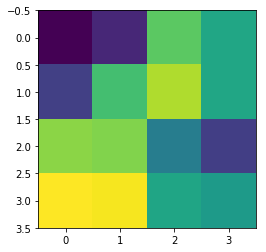

In [11]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [12]:
def get_bottleneck_features(model, input_imgs):
    
    features = model.predict(input_imgs, verbose=0)
    return features

In [13]:
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (3000, 8192) 	Validation Bottleneck Features: (1000, 8192)


In [14]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 3000 samples, validate on 1000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
3000/3000 [==============================] - 1s 218us/sample - loss: 0.4464 - acc: 0.7837 - val_loss: 0.2645 - val_acc: 0.8860
Epoch 2/30
3000/3000 [==============================] - 0s 105us/sample - loss: 0.2900 - acc: 0.8810 - val_loss: 0.2337 - val_acc: 0.9050
Epoch 3/30
3000/3000 [==============================] - 0s 105us/sample - loss: 0.2562 - acc: 0.8933 - val_loss: 0.3329 - val_acc: 0.8410
Epoch 4/30
3000/3000 [==============================] - 0s 105us/sample - loss: 0.2080 - acc: 0.9193 - val_loss: 0.2354 - val_acc: 0.9010
Epoch 5/30
3000/3000 [==============================] - 0s 105us/sample - loss: 0.1796 - acc: 0.9237 - val_loss: 0.3725 - val_acc: 0.8630
Epoch 6/30
3000/3000 [==============================] - 0s 105us/sample - loss: 0.1558 - acc: 0.9370 - val_loss: 0.2563 - val_acc: 0.8940
Epoch 7/30
3000/3000 [==============================] - 0s 105us/sample - lo

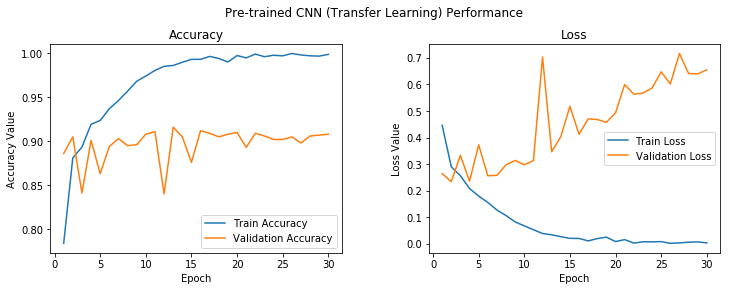

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [17]:
model.save('cats_dogs_tlearn_basic_cnn.h5')

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [19]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 8192)              14714688  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 4,457,985
Non-trainable params: 14,714,688
________________________________________________________

In [20]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/100
100/100 [==============================] - 11s 111ms/step - loss: 0.6659 - acc: 0.5957 - val_loss: 0.5014 - val_acc: 0.7990
Epoch 2/100
100/100 [==============================] - 10s 100ms/step - loss: 0.5641 - acc: 0.7130 - val_loss: 0.4138 - val_acc: 0.8330
Epoch 3/100
100/100 [==============================] - 10s 101ms/step - loss: 0.5016 - acc: 0.7590 - val_loss: 0.3601 - val_acc: 0.8530
Epoch 4/100
100/100 [==============================] - 10s 100ms/step - loss: 0.4782 - acc: 0.7770 - val_loss: 0.3489 - val_acc: 0.8570
Epoch 5/100
100/100 [==============================] - 10s 100ms/step - loss: 0.4571 - acc: 0.7890 - val_loss: 0.3022 - val_acc: 0.8630
Epoch 6/100
100/100 [==============================] - 10s 101ms/step - loss: 0.4327 - acc: 0.7963 - val_loss: 0.2852 - val_acc: 0.8750
Epoch 7/100
100/100 [==============================] - 10s 101ms/step - loss: 0.4189 - acc: 0.8047 - val_loss: 0.2739 - val_acc: 0.8780
Epoch 8/100
100/100 [===========================

100/100 [==============================] - 10s 102ms/step - loss: 0.3356 - acc: 0.8520 - val_loss: 0.2285 - val_acc: 0.9100
Epoch 39/100
100/100 [==============================] - 10s 101ms/step - loss: 0.3254 - acc: 0.8603 - val_loss: 0.2316 - val_acc: 0.9040
Epoch 40/100
100/100 [==============================] - 10s 101ms/step - loss: 0.3152 - acc: 0.8647 - val_loss: 0.2343 - val_acc: 0.9050
Epoch 41/100
100/100 [==============================] - 10s 101ms/step - loss: 0.3172 - acc: 0.8620 - val_loss: 0.2318 - val_acc: 0.9050
Epoch 42/100
100/100 [==============================] - 10s 100ms/step - loss: 0.3251 - acc: 0.8540 - val_loss: 0.2299 - val_acc: 0.9100
Epoch 43/100
100/100 [==============================] - 10s 101ms/step - loss: 0.3221 - acc: 0.8560 - val_loss: 0.2305 - val_acc: 0.9070
Epoch 44/100
100/100 [==============================] - 10s 100ms/step - loss: 0.3219 - acc: 0.8620 - val_loss: 0.2300 - val_acc: 0.9070
Epoch 45/100
100/100 [==============================] 

100/100 [==============================] - 10s 100ms/step - loss: 0.2928 - acc: 0.8800 - val_loss: 0.2426 - val_acc: 0.9020
Epoch 76/100
100/100 [==============================] - 10s 100ms/step - loss: 0.2886 - acc: 0.8753 - val_loss: 0.2319 - val_acc: 0.9130
Epoch 77/100
100/100 [==============================] - 10s 101ms/step - loss: 0.2837 - acc: 0.8777 - val_loss: 0.2407 - val_acc: 0.9080
Epoch 78/100
100/100 [==============================] - 10s 102ms/step - loss: 0.2944 - acc: 0.8763 - val_loss: 0.2441 - val_acc: 0.9100
Epoch 79/100
100/100 [==============================] - 10s 101ms/step - loss: 0.2895 - acc: 0.8787 - val_loss: 0.2440 - val_acc: 0.9080
Epoch 80/100
100/100 [==============================] - 10s 100ms/step - loss: 0.2997 - acc: 0.8710 - val_loss: 0.2413 - val_acc: 0.9120
Epoch 81/100
100/100 [==============================] - 10s 101ms/step - loss: 0.2951 - acc: 0.8747 - val_loss: 0.2370 - val_acc: 0.9080
Epoch 82/100
100/100 [==============================] 

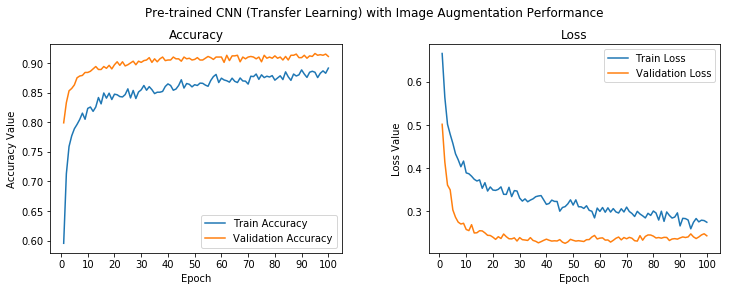

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [22]:
model.save('cats_dogs_tlearn_img_aug_cnn.h5')

In [23]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: [<tf.Variable 'block4_conv1_1/kernel:0' shape=(3, 3, 256, 512) dtype=float32>, <tf.Variable 'block4_conv1_1/bias:0' shape=(512,) dtype=float32>, <tf.Variable 'block4_conv2_1/kernel:0' shape=(3, 3, 512, 512) dtype=float32>, <tf.Variable 'block4_conv2_1/bias:0' shape=(512,) dtype=float32>, <tf.Variable 'block4_conv3_1/kernel:0' shape=(3, 3, 512, 512) dtype=float32>, <tf.Variable 'block4_conv3_1/bias:0' shape=(512,) dtype=float32>, <tf.Variable 'block5_conv1_1/kernel:0' shape=(3, 3, 512, 512) dtype=float32>, <tf.Variable 'block5_conv1_1/bias:0' shape=(512,) dtype=float32>, <tf.Variable 'block5_conv2_1/kernel:0' shape=(3, 3, 512, 512) dtype=float32>, <tf.Variable 'block5_conv2_1/bias:0' shape=(512,) dtype=float32>, <tf.Variable 'block5_conv3_1/kernel:0' shape=(3, 3, 512, 512) dtype=float32>, <tf.Variable 'block5_conv3_1/bias:0' shape=(512,) dtype=float32>]


In [24]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9dc80d0e80>,input_2,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9dc8084160>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9dc8131e10>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9dc809d6a0>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9dc809d940>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9dc806d080>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9dc8005ef0>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9dc80201d0>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9dc803c9e8>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9dc0353780>,block3_conv3,False


In [25]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [26]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 8192)              14714688  
_________________________________________________________________
dense_6 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 17,437,185
Non-trainable params: 1,735,488
________________________________________________________

In [27]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/100
100/100 [==============================] - 11s 110ms/step - loss: 0.6117 - acc: 0.6457 - val_loss: 0.3438 - val_acc: 0.8740
Epoch 2/100
100/100 [==============================] - 10s 105ms/step - loss: 0.4241 - acc: 0.8080 - val_loss: 0.3129 - val_acc: 0.8780
Epoch 3/100
100/100 [==============================] - 10s 103ms/step - loss: 0.3433 - acc: 0.8507 - val_loss: 0.2106 - val_acc: 0.9220
Epoch 4/100
100/100 [==============================] - 10s 103ms/step - loss: 0.2879 - acc: 0.8767 - val_loss: 0.4158 - val_acc: 0.8540
Epoch 5/100
100/100 [==============================] - 10s 104ms/step - loss: 0.2665 - acc: 0.8910 - val_loss: 0.1529 - val_acc: 0.9390
Epoch 6/100
100/100 [==============================] - 10s 103ms/step - loss: 0.2513 - acc: 0.8997 - val_loss: 0.1691 - val_acc: 0.9380
Epoch 7/100
100/100 [==============================] - 10s 102ms/step - loss: 0.2404 - acc: 0.9040 - val_loss: 0.1414 - val_acc: 0.9420
Epoch 8/100
100/100 [===========================

100/100 [==============================] - 10s 104ms/step - loss: 0.0538 - acc: 0.9777 - val_loss: 0.1883 - val_acc: 0.9610
Epoch 39/100
100/100 [==============================] - 10s 104ms/step - loss: 0.0591 - acc: 0.9750 - val_loss: 0.1555 - val_acc: 0.9620
Epoch 40/100
100/100 [==============================] - 10s 103ms/step - loss: 0.0492 - acc: 0.9817 - val_loss: 0.1769 - val_acc: 0.9680
Epoch 41/100
100/100 [==============================] - 10s 103ms/step - loss: 0.0609 - acc: 0.9763 - val_loss: 0.1461 - val_acc: 0.9680
Epoch 42/100
100/100 [==============================] - 10s 103ms/step - loss: 0.0491 - acc: 0.9840 - val_loss: 0.1685 - val_acc: 0.9690
Epoch 43/100
100/100 [==============================] - 10s 104ms/step - loss: 0.0563 - acc: 0.9790 - val_loss: 0.1496 - val_acc: 0.9630
Epoch 44/100
100/100 [==============================] - 10s 105ms/step - loss: 0.0478 - acc: 0.9813 - val_loss: 0.1561 - val_acc: 0.9580
Epoch 45/100
100/100 [==============================] 

100/100 [==============================] - 10s 104ms/step - loss: 0.0271 - acc: 0.9887 - val_loss: 0.2866 - val_acc: 0.9530
Epoch 76/100
100/100 [==============================] - 10s 104ms/step - loss: 0.0271 - acc: 0.9903 - val_loss: 0.2619 - val_acc: 0.9530
Epoch 77/100
100/100 [==============================] - 10s 104ms/step - loss: 0.0360 - acc: 0.9917 - val_loss: 0.2460 - val_acc: 0.9590
Epoch 78/100
100/100 [==============================] - 10s 104ms/step - loss: 0.0306 - acc: 0.9887 - val_loss: 0.3727 - val_acc: 0.9540
Epoch 79/100
100/100 [==============================] - 10s 104ms/step - loss: 0.0364 - acc: 0.9880 - val_loss: 0.2194 - val_acc: 0.9600
Epoch 80/100
100/100 [==============================] - 10s 103ms/step - loss: 0.0392 - acc: 0.9867 - val_loss: 0.3149 - val_acc: 0.9490
Epoch 81/100
100/100 [==============================] - 11s 105ms/step - loss: 0.0360 - acc: 0.9870 - val_loss: 0.3941 - val_acc: 0.9470
Epoch 82/100
100/100 [==============================] 

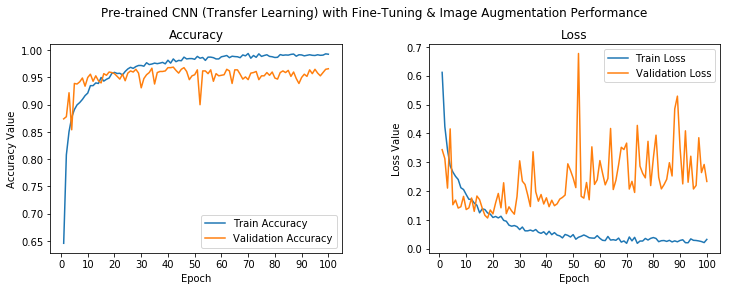

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Fine-Tuning & Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [29]:
model.save('cats_dogs_tlearn_finetune_img_aug_cnn.h5')